In [ ]:
"""
 El objetivo siguiente es: 
- Predecir la probabilidad de que un usuario compre basado en comportamiento y transacciones.
- Evaluar efectividad de campañas de marketing mediante uplift modeling.

Cliente objetivo:
- Sellers premium
- Marcas interesadas en targeting
- Equipos internos de marketing

Outputs:
- Propensity score (0-1)
- Uplift score (0-1)
- Segmentación de usuarios
- Visualizaciones explicativas (SHAP, Gains, Qini)
"""

In [3]:
!pip install scikit-uplift


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#Carga de datos
from sklift.datasets import fetch_hillstrom
import pandas as pd

# Cargar dataset Hillstrom
dataset = fetch_hillstrom(target_col="conversion", return_X_y_t=True)
X, y, treatment = dataset

# Convertir a DataFrame
X = pd.DataFrame(X)
y = pd.Series(y, name="compra")
treatment = pd.Series(treatment, name="grupo")  # 0 = control, 1 = tratamiento

# Concatenar todo en un solo DataFrame para trabajar más fácil
df = pd.concat([X, y, treatment], axis=1)

# Mostrar ejemplo
df.head(10)

Hillstrom dataset:   0%|          | 0.00/443k [00:00<?, ?iB/s]

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,compra,grupo
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,0,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,0,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,0,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,0,Womens E-Mail
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,0,Womens E-Mail
6,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,0,Womens E-Mail
7,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,0,Womens E-Mail
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,0,Mens E-Mail
9,10,1) $0 - $100,32.84,0,1,Urban,1,Web,0,Womens E-Mail


NameError: name 'hillstrom' is not defined

In [6]:
#Para descargar el conjunto de datos 
from sklift.datasets import fetch_hillstrom
import pandas as pd

# Cargar dataset Hillstrom (scikit-uplift lo descarga si no existe)
dataset = fetch_hillstrom(target_col="conversion", return_X_y_t=True)

# Separar datos
X, y, treatment = dataset

# Convertir a DataFrame / Series
X = pd.DataFrame(X)
y = pd.Series(y, name="compra")
treatment = pd.Series(treatment, name="grupo")

# Unir todo en un DataFrame
hillstrom_df = pd.concat([X, y, treatment], axis=1)

# Mostrar primera parte del dataset
hillstrom_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,compra,grupo
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,0,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,0,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,0,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,0,Womens E-Mail


In [8]:
#Preparacion
import pandas as pd
from sklearn.model_selection import train_test_split

# Usar el dataframe correcto cargado antes
df = hillstrom_df.copy()

# Seleccionar features, target y tratamiento
features = ["recency", "history", "mens", "womens", "newbie", "channel"]
target = "compra"
treatment_col = "grupo"

X = df[features + [treatment_col]]
y = df[target]

# One-hot encoding para variables categóricas
X = pd.get_dummies(X, columns=["newbie", "channel"], drop_first=True)

# Train / Test split estratificado por el target
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Verificación básica
print("X_train shape:", X_train.shape)
print("Distribución y_train:")
print(y_train.value_counts(normalize=True))

X_train.head()

X_train shape: (51200, 8)
Distribución y_train:
compra
0    0.990977
1    0.009023
Name: proportion, dtype: float64


,recency,history,mens,womens,grupo,newbie_1,channel_Phone,channel_Web
63250,11,29.99,1,0,Womens E-Mail,True,False,True
22437,5,153.25,1,0,Womens E-Mail,False,False,True
503,6,528.03,1,1,Womens E-Mail,True,False,False
10648,5,57.85,1,0,Womens E-Mail,False,True,False
48649,3,50.82,0,1,Mens E-Mail,True,True,False


Distribución del target (compra):
compra
0    0.990969
1    0.009031
Name: proportion, dtype: float64


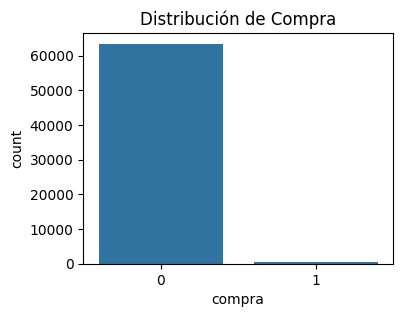


Tasa de compra por grupo:
grupo
Mens E-Mail      0.012531
No E-Mail        0.005726
Womens E-Mail    0.008837
Name: compra, dtype: float64


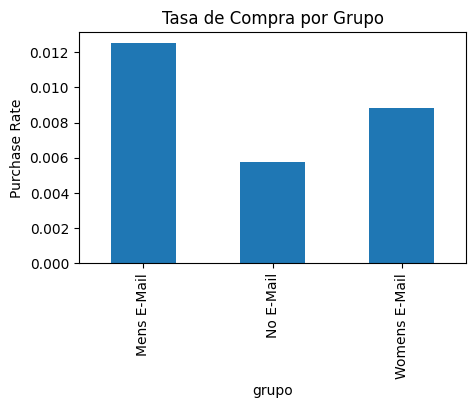


Estadísticos descriptivos:


,recency,history,mens,womens
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719
std,3.507592,256.158608,0.497393,0.497526
min,1.000000,29.990000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000
75%,9.000000,325.657500,1.000000,1.000000
max,12.000000,3345.930000,1.000000,1.000000



Promedios por compra:


,recency,history,mens,womens
compra,,,,
0,5.771909,241.366593,0.550913,0.549115
1,4.866782,320.985952,0.564014,0.615917



Tasa de compra por channel:


channel
Multichannel    0.012626
Web             0.009321
Phone           0.007744
Name: compra, dtype: float64

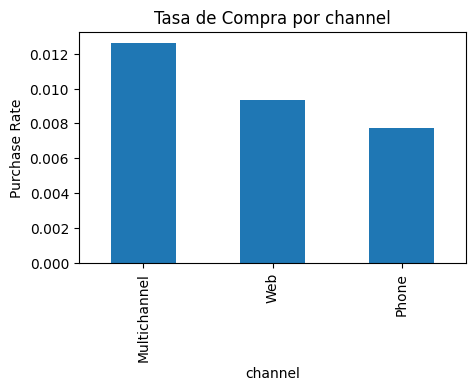


Tasa de compra por newbie:


newbie
0    0.010108
1    0.007964
Name: compra, dtype: float64

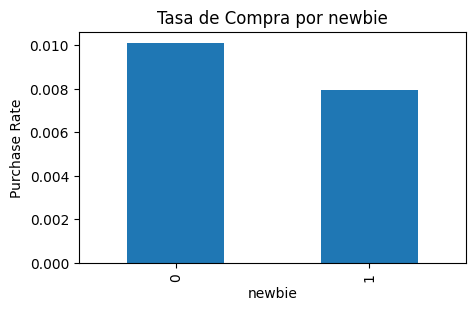

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = hillstrom_df.copy()

# -------------------------
# 1️⃣ Distribución del target
# -------------------------
print("Distribución del target (compra):")
print(df["compra"].value_counts(normalize=True))

plt.figure(figsize=(4,3))
sns.countplot(x="compra", data=df)
plt.title("Distribución de Compra")
plt.show()

# -------------------------
# 2️⃣ Compra por grupo (control vs tratamiento)
# -------------------------
group_purchase = df.groupby("grupo")["compra"].mean()
print("\nTasa de compra por grupo:")
print(group_purchase)

plt.figure(figsize=(5,3))
group_purchase.plot(kind="bar")
plt.title("Tasa de Compra por Grupo")
plt.ylabel("Purchase Rate")
plt.show()

# -------------------------
# 3️⃣ Estadísticos descriptivos numéricos
# -------------------------
numeric_features = ["recency", "history", "mens", "womens"]
print("\nEstadísticos descriptivos:")
display(df[numeric_features].describe())

# -------------------------
# 4️⃣ Comparación compradores vs no compradores
# -------------------------
purchase_stats = df.groupby("compra")[numeric_features].mean()
print("\nPromedios por compra:")
display(purchase_stats)

# -------------------------
# 5️⃣ Análisis categórico
# -------------------------
categorical_features = ["channel", "newbie"]

for col in categorical_features:
    rate = df.groupby(col)["compra"].mean().sort_values(ascending=False)
    print(f"\nTasa de compra por {col}:")
    display(rate)

    plt.figure(figsize=(5,3))
    rate.plot(kind="bar")
    plt.title(f"Tasa de Compra por {col}")
    plt.ylabel("Purchase Rate")
    plt.show()




In [10]:
# =========================
# Feature Engineering – Propensión a Compra
# =========================

import pandas as pd
import numpy as np

df = hillstrom_df.copy()

# -------------------------
# 1️⃣ Features derivadas básicas
# -------------------------

# Recency invertida (más reciente = mayor valor)
df["recency_inv"] = 1 / (df["recency"] + 1)

# Log del gasto histórico
df["log_history"] = np.log1p(df["history"])

# Indicador de interés por género
df["interest_mens"] = (df["mens"] == 1).astype(int)
df["interest_womens"] = (df["womens"] == 1).astype(int)

# -------------------------
# 2️⃣ Interacciones
# -------------------------

# Gasto histórico ajustado por recency
df["history_x_recency"] = df["history"] * df["recency_inv"]

# Nuevo cliente con alto gasto
df["newbie_high_history"] = (
    (df["newbie"] == 1) & (df["history"] > df["history"].median())
).astype(int)

# -------------------------
# 3️⃣ Binning / Buckets
# -------------------------

# Buckets de recency
df["recency_bucket"] = pd.qcut(
    df["recency"],
    q=4,
    labels=["very_recent", "recent", "old", "very_old"]
)

# Buckets de gasto histórico
df["history_bucket"] = pd.qcut(
    df["history"],
    q=4,
    labels=["low", "medium", "high", "very_high"]
)

# -------------------------
# 4️⃣ Preparar dataset final para modelado
# -------------------------

features = [
    "recency",
    "history",
    "recency_inv",
    "log_history",
    "history_x_recency",
    "interest_mens",
    "interest_womens",
    "newbie_high_history",
    "recency_bucket",
    "history_bucket",
    "channel"
]

X = df[features]
y = df["compra"]

# One-hot encoding para categóricas
X = pd.get_dummies(
    X,
    columns=["recency_bucket", "history_bucket", "channel"],
    drop_first=True
)

print("Shape final de X:", X.shape)
X.head()

Shape final de X: (64000, 16)


,recency,history,recency_inv,log_history,history_x_recency,interest_mens,interest_womens,newbie_high_history,recency_bucket_recent,recency_bucket_old,recency_bucket_very_old,history_bucket_medium,history_bucket_high,history_bucket_very_high,channel_Phone,channel_Web
0,10,142.44,0.090909,4.965917,12.949091,1,0,0,False,False,True,True,False,False,True,False
1,6,329.08,0.142857,5.799335,47.011429,1,1,1,True,False,False,False,False,True,False,True
2,7,180.65,0.125000,5.202082,22.581250,0,1,1,False,True,False,False,True,False,False,True
3,9,675.83,0.100000,6.517420,67.583000,1,0,1,False,True,False,False,False,True,False,True
4,2,45.34,0.333333,3.836006,15.113333,1,0,0,False,False,False,False,False,False,False,True


ROC-AUC: 0.6190

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     12684
           1       0.01      0.56      0.03       116

    accuracy                           0.63     12800
   macro avg       0.50      0.59      0.40     12800
weighted avg       0.98      0.63      0.76     12800



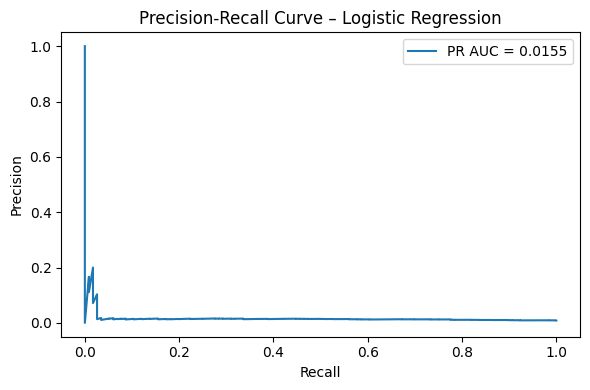

In [11]:
# =========================
# Entrenamiento – Modelo 1: Regresión Logística (Propensión)
# =========================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Train / Test split estratificado
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -------------------------
# Entrenar Regresión Logística
# -------------------------
log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

log_model.fit(X_train, y_train)

# -------------------------
# Predicciones
# -------------------------
y_pred_proba = log_model.predict_proba(X_test)[:, 1]
y_pred = log_model.predict(X_test)

# -------------------------
# Métricas
# -------------------------
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}\n")
print(classification_report(y_test, y_pred))

# -------------------------
# Precision-Recall Curve
# -------------------------
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()


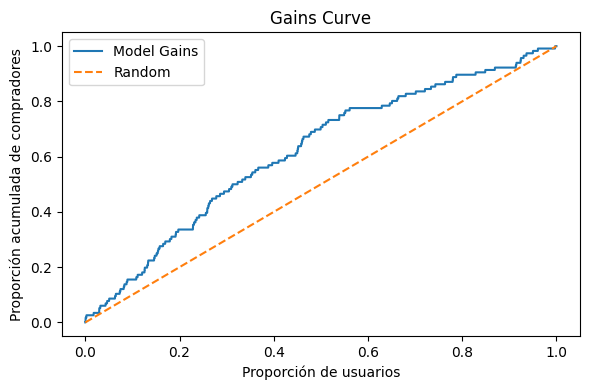

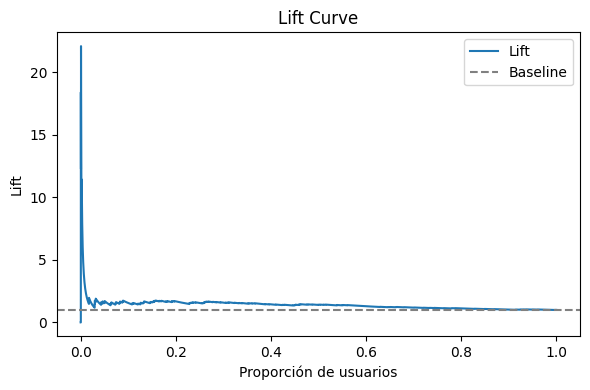

In [12]:
# =========================
# Gains / Lift Curve – Propensión a Compra
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DataFrame con scores
df_eval = pd.DataFrame({
    "y_true": y_test.values,
    "y_score": y_pred_proba
}).sort_values("y_score", ascending=False).reset_index(drop=True)

# Percentiles
df_eval["cum_users"] = (np.arange(len(df_eval)) + 1) / len(df_eval)
df_eval["cum_positives"] = df_eval["y_true"].cumsum()
total_positives = df_eval["y_true"].sum()

# Gains y Lift
df_eval["gains"] = df_eval["cum_positives"] / total_positives
df_eval["random"] = df_eval["cum_users"]
df_eval["lift"] = df_eval["gains"] / df_eval["cum_users"]

# ---- Plot Gains ----
plt.figure(figsize=(6,4))
plt.plot(df_eval["cum_users"], df_eval["gains"], label="Model Gains")
plt.plot(df_eval["cum_users"], df_eval["random"], linestyle="--", label="Random")
plt.xlabel("Proporción de usuarios")
plt.ylabel("Proporción acumulada de compradores")
plt.title("Gains Curve")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot Lift ----
plt.figure(figsize=(6,4))
plt.plot(df_eval["cum_users"], df_eval["lift"], label="Lift")
plt.axhline(1, linestyle="--", color="gray", label="Baseline")
plt.xlabel("Proporción de usuarios")
plt.ylabel("Lift")
plt.title("Lift Curve")
plt.legend()
plt.tight_layout()
plt.show()


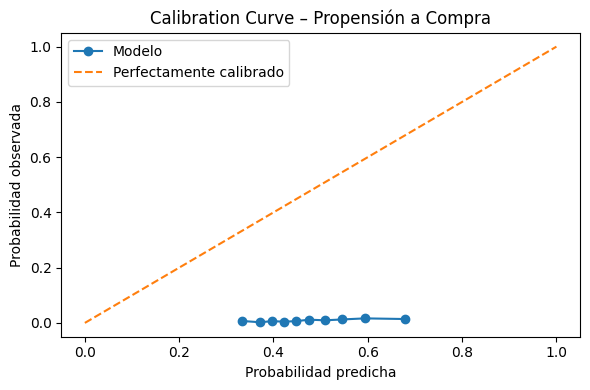

In [13]:
# =========================
# Calibration Curve – Propensión a Compra
# =========================

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Calcular curva de calibración
prob_true, prob_pred = calibration_curve(
    y_test,
    y_pred_proba,
    n_bins=10,
    strategy="quantile"
)

# Plot
plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker="o", label="Modelo")
plt.plot([0,1], [0,1], linestyle="--", label="Perfectamente calibrado")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad observada")
plt.title("Calibration Curve – Propensión a Compra")
plt.legend()
plt.tight_layout()
plt.show()


ROC-AUC: 0.5603

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     12684
           1       0.02      0.27      0.03       116

    accuracy                           0.85     12800
   macro avg       0.50      0.56      0.47     12800
weighted avg       0.98      0.85      0.91     12800



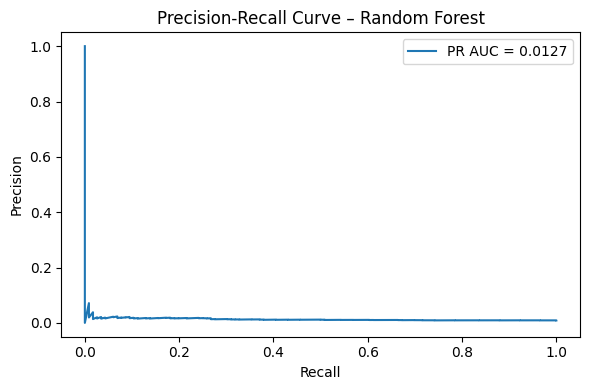

In [14]:
# =========================
# Entrenamiento – Modelo 2: Random Forest (Propensión)
# =========================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Train / Test split (mismo esquema)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Modelo
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,
    min_samples_leaf=50,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predicciones
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
y_pred = rf_model.predict(X_test)

# Métricas
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}\n")
print(classification_report(y_test, y_pred))

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = hillstrom_df.copy()

# crear features (si no existen)
df["recency_inv"] = 1 / (df["recency"] + 1)
df["log_history"] = np.log1p(df["history"])
df["history_x_recency"] = df["history"] * df["recency_inv"]
df["interest_mens"] = (df["mens"] == 1).astype(int)
df["interest_womens"] = (df["womens"] == 1).astype(int)
df["newbie_high_history"] = ((df["newbie"] == 1) & (df["history"] > df["history"].median())).astype(int)

df["recency_bucket"] = pd.qcut(df["recency"], q=4, labels=["very_recent", "recent", "old", "very_old"])
df["history_bucket"] = pd.qcut(df["history"], q=4, labels=["low", "medium", "high", "very_high"])

features = [
    "recency", "history", "mens", "womens", "newbie", "channel",
    "recency_inv", "log_history", "history_x_recency",
    "interest_mens", "interest_womens", "newbie_high_history",
    "recency_bucket", "history_bucket"
]

X = df[features]
X = pd.get_dummies(X, columns=["recency_bucket", "history_bucket", "channel"], drop_first=True)

y = df["compra"]
t = (df["grupo"] != "control").astype(int)

X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.2, random_state=42, stratify=y
)

model_control = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
model_treat = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")

model_control.fit(X_train[t_train == 0], y_train[t_train == 0])
model_treat.fit(X_train[t_train == 1], y_train[t_train == 1])

p_control = model_control.predict_proba(X_test)[:, 1]
p_treat = model_treat.predict_proba(X_test)[:, 1]

uplift_df = X_test.copy()
uplift_df["uplift_score"] = p_treat - p_control
uplift_df["treatment"] = t_test.values
uplift_df["outcome"] = y_test.values

uplift_df.head()



ValueError: Found array with 0 sample(s) (shape=(0, 19)) while a minimum of 1 is required by LogisticRegression.